In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_channels=16, num_classes=100):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_channels * 4 * 4 * 4, num_classes) # Предполагаем, что размер входного изображения — 32x32

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # Все размеры, кроме размера партии
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def create_model(num_params):
    if num_params < 5000:
        num_channels = 8
    elif num_params < 20000:
        num_channels = 16
    elif num_params < 50000:
        num_channels = 32
    elif num_params < 100000:
        num_channels = 64
    else:
        num_channels = 128
    
    model = CustomCNN(num_channels=num_channels)
    return model

In [3]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, trainloader, criterion, optimizer, epochs=10, model_name='model'):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }, f'{model_name}_checkpoint_{epoch+1}.pth')

    print('Training completed')

def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss

def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

models_params = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
models_accuracies = []

for num_params in models_params:
    model = create_model(num_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print(f'Training model with {num_params} parameters')
    train_model(model, trainloader, criterion, optimizer, epochs=10)
    accuracy = test_model(model, testloader)
    models_accuracies.append(accuracy)
    print(f'Model with {num_params} parameters, Accuracy: {accuracy}%')

Training model with 1000 parameters
Epoch 1, Loss: 3.879669899764061
Epoch 2, Loss: 3.1194309803247453
Epoch 3, Loss: 2.8021453192722796
Epoch 4, Loss: 2.6119800704538823
Epoch 5, Loss: 2.482416793602705
Epoch 6, Loss: 2.390837928240299
Epoch 7, Loss: 2.319550926577449
Epoch 8, Loss: 2.2695564170640705
Epoch 9, Loss: 2.2273761148750784
Epoch 10, Loss: 2.1920417047721146
Training completed
Model with 1000 parameters, Accuracy: 33.75%
Training model with 5000 parameters
Epoch 1, Loss: 3.8177784592723847
Epoch 2, Loss: 2.9668829001283648
Epoch 3, Loss: 2.5576516954386235
Epoch 4, Loss: 2.2879935706084966
Epoch 5, Loss: 2.1039087064927817
Epoch 6, Loss: 1.9567392313152552
Epoch 7, Loss: 1.8494945566108822
Epoch 8, Loss: 1.7550282052454353
Epoch 9, Loss: 1.6797148272976279
Epoch 10, Loss: 1.6178744547952713
Training completed
Model with 5000 parameters, Accuracy: 38.61%
Training model with 10000 parameters
Epoch 1, Loss: 3.784428852815628
Epoch 2, Loss: 2.94953924131155
Epoch 3, Loss: 2.562

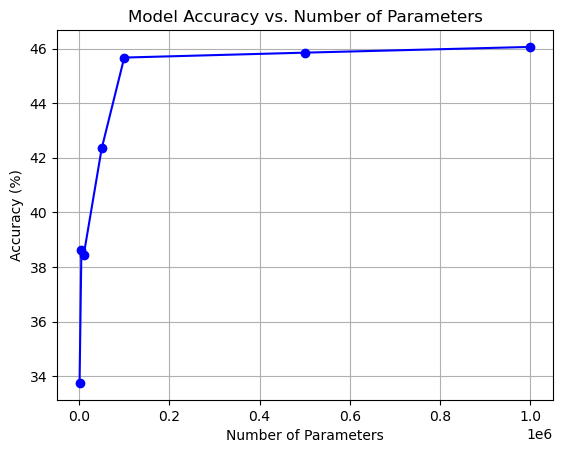

In [5]:
import matplotlib.pyplot as plt

plt.plot(models_params, models_accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
